
# <span style="color:#bce35b">Autism Spectrum Disorder (ASD)</span>

## <span style="color:#ae8bd5">Exploratory Data Analysis</span>

<span style="color:#9c9c9c; font-size:16px">


**Author**: Patrick Weatherford <br>
**Affiliation**: Bellevue University <br>
**Class**: DSC 530 - Data Exploration and Analysis
    
</span>

***

<br>

## <span style="color:#ae8bd6">Abstract</span>

**Outcome Variable**: 
- <u>ASD Prevalence</u>: Data obtained from childhealthdata.org for children aged 3-17 for years 2019-2020. This would mean that the children were born anywhere from 2002-2017. 

<br>

**Predictor Variables**:
- <u>Estimated vaccination rate %</u>: Data obtained from the CDC for children born 2014-2017. Aggregates the estimated vaccination rates for the below vaccines:
    - Combined 7 Series
    - DTaP (≥3 Doses)
    - Hep A (≥1 Dose)
    - Hep B (≥1 Dose, 3 Day (Birth Dose))
    - Hib (Full Series)
    - Influenza
    - MMR (≥1 Dose)
    - PCV (≥3 Doses)
    - Polio (≥3 Doses)
    - Rotavirus
    - Varicella (≥1 Dose)
    
<br>

- <u>Father age >= 40 rate</u>: Data obtained from CDC BRFSS birth natality data for year 2016. This variable tracks the rate of births where the father's age was over 40 when the baby was born.

<br>

- <u>Mother age >= 40 rate</u>: Data obtained from CDC BRFSS birth natality data for year 2016. This variable tracks the rate of births where the mother's documented age was over 40 when the baby was born.

<br>

- <u>Premature birth rate</u>: Data obtained from CDC BRFSS birth natality data for year 2016. This variable is the prevalence of preterm babies. A preterm baby is defined as baby born before 37 weeks of pregnancy have been completed.

<br>

- <u>U.S. Population</u>: Data obtained from Census.gov for the year 2020. This variable shows the reported population for each state.

<br>

- <u>Obesity rate</u>: Data obtained from CDC BRFSS for year 2015. This variable is the prevalence of obesity for adults. A person is considered obese if their BMI (Body Mass Index) is greater than or equal to 30. 
    <br>$BMI=\frac{weight(kg)}{(height(meters))^2}$

<br>

- <u>Binge Drinking Rate</u>: Data obtained from CDF BRFSS for year 2015. This variable is the prevalence of binge drinking for adults. Age adjusted to the 2000 US Census. Binge drinking is defined as a pattern of alcohol consumption that brings the blood alcohol concentration (BAC) level to 0.08% or more. This pattern of drinking usually corresponds to 5 or more drinks on a single occasion for men or 4 or more drinks on a single occasion for women, generally within about 2 hours.

<br>

## <span style="color:#ae8bd6">Load Packages</span>

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
import os
import functools
import json
import bisect
from pprint import pprint


<br>

## <span style="color:#ae8bd6">Change Working Directory</span>

In [2]:
# Change working directory
wd_path = ( os.environ["HOMEPATH"] + '\OneDrive - Bellevue University\Bellevue_University\DSC 530 - Data Exploration and Analysis\Project' )
os.chdir(wd_path)

<br>

## <span style="color:#ae8bd6">Custom Functions</span>

In [71]:
def desc_var(var):
    
    desc_dict = stats.describe(var)._asdict()

    desc_dict['standard deviation'] = desc_dict['variance']**.5
    desc_dict['min'] = desc_dict['minmax'][0]
    desc_dict['max'] = desc_dict['minmax'][1]
    del desc_dict['minmax']

    return desc_dict



def join_multi_index(df_list, how='inner', left_index=True, right_index=True):
    
    joined_df = df_list[0]
    total_tables = len(df_merge_list)

    for count, df in enumerate(df_merge_list, start=1):
        if count >= total_tables:
            break
        else:
            joined_df = pd.merge(joined_df, df_merge_list[count], how=how, left_index=left_index, right_index=right_index)
            
    return joined_df



def detect_outliers(var):
    
    ## Defining outlier if the zscore is greater than or less than 3
    z_outlier = list(var[np.abs(stats.zscore(var)) > 3])
    
    ## Defining outlier if the value is less than the 25th percentile - 1.5 * IQR or is greater than the 75th percentile - 1.5 * IQR
    q25, q75 = np.percentile(var, [25, 75])  
    iqr = q75-q25
    
    ## Tukey inner fence
    iqr_low_inner = q25 - 1.5 * iqr
    iqr_high_inner = q75 + 1.5 * iqr
    iqr_outliers_inner = list(var[(var < iqr_low_inner) | (var > iqr_high_inner)])
    
    ## Tukey outer fence
    iqr_low_outer = q25 - 3 * iqr
    iqr_high_outer = q75 + 3 * iqr
    iqr_outliers_outer = list(var[(var < iqr_low_outer) | (var > iqr_high_outer)])
    
    outlier_dict = {
        'Z-Outliers':z_outlier
        , 'Tukey Inner Fence':iqr_outliers_inner
        , 'Tukey Outer Fence':iqr_outliers_outer
        
    }
    
    return outlier_dict


def var_summary(var_array, **kwargs):
    ## Preparing subplot fig and axes
    
    sup_title = kwargs.pop('sup_title', '')
    ax1_title = kwargs.pop('ax1_title', 'Histogram w/KDE')
    ax1_xlabel = kwargs.pop('ax1_xlabel', ' ')
    ax1_ylabel = kwargs.pop('ax1_ylabel', ' ')
    ax2_title = kwargs.pop('ax2_title', 'CDF')
    ax2_xlabel = kwargs.pop('ax2_xlabel', ' ')
    ax2_ylabel = kwargs.pop('ax2_ylabel', ' ')
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    fig.suptitle(sup_title, weight='bold', size=16)
    ax[0].set_title('Histogram w/KDE')
    ax[0].set_xlabel(ax1_xlabel)
    ax[0].set_ylabel(ax1_ylabel)
    ax[1].set_title('CDF')
    ax[1].set_xlabel(ax2_xlabel)
    ax[1].set_ylabel(ax2_ylabel)

    ## Plotting the histogram with KDE
    sns.histplot(var_array, kde=True, line_kws={'linewidth':2}, legend=False, ax=ax[0])

    ## Plotting the CDF
    sns.ecdfplot(var_array, linewidth=2, ax=ax[1])

    plt.show()


    pprint(desc_var(var_array), sort_dicts=False)
    print('\n')
    pprint(detect_outliers(var_array), sort_dicts=False)
    
def cdf_array(array, remove_na=True):
    if remove_na:
        array = array[~(np.isnan(array))]
    else:
        pass
    
    val, freq = np.unique(array, return_counts=True)
    prob = freq/len(array)

    cdf = np.cumsum(prob)
    return (val, cdf)



def cdf_percentile(array, percentile, remove_na=True):
    percentile = percentile/100
    
    index = bisect.bisect_left(array[1], percentile)
    return array[0][index]

<br>

## <span style="color:#ae8bd6">Import Data</span>


<a id='_create_initial_dataframes'></a>

### Create Initial DataFrames

In [3]:
# Natality Data by State
natality_df = pd.read_excel('Data/Birth_Natality_Data_2016.xlsx', sheet_name='NatalityData')
natality_df = natality_df.drop(columns=[
    'Father Age Unknown'
    , 'Father Age < 40'
    , 'Father Age >= 40'
    , 'Mother Age < 40'
    , 'Mother Age >= 40'
])
natality_df.iloc[np.r_[0:5, -5:0]]

,State,Total Births,Father Age >= 40 Rate,Mother Age >= 40 Rate,Premature Births,Premature Birth Rate
0,Alabama,59151,6.74,1.62,7083,11.97
1,Alaska,11209,8.68,2.18,999,8.91
2,Arizona,84520,8.92,2.66,7654,9.06
3,Arkansas,38274,6.33,1.55,4157,10.86
4,California,488827,13.22,4.46,42074,8.61
45,Virginia,102460,11.58,3.48,9792,9.56
46,Washington,90505,10.43,3.34,7364,8.14
47,West Virginia,19079,7.57,1.49,2259,11.84
48,Wisconsin,66615,6.52,2.21,6385,9.58
49,Wyoming,7386,7.07,1.99,700,9.48


<br><br>

In [4]:
# Autism Spectrum Disorder (ASD) Prevalence by State
state_asd_df = pd.read_excel('Data/ASD_Prevalence_Age_3-17yrs_by_State_Survey_2019-2020.xlsx', sheet_name='PrevalenceData')
state_asd_df.iloc[np.r_[0:5, -5:0]]  # view first and last 5 rows

,State,Currently has condition %,Does not have condition %
0,Alabama,3.1,96.8
1,Alaska,3.2,96.8
2,Arizona,3.3,96.4
3,Arkansas,2.5,97.5
4,California,3.0,96.7
45,Virginia,3.0,96.9
46,Washington,2.4,97.4
47,West Virginia,2.5,97.4
48,Wisconsin,4.3,95.7
49,Wyoming,2.0,98.0


In [5]:
# remove state column to avoid duplicate columns in final join
state_asd_df = state_asd_df[['Currently has condition %']]

<br><br>

In [6]:
# Census population data by State
state_pop_df = pd.read_excel('Data/2020_Census_Data_by_State.xlsx', sheet_name='CensusData')
state_pop_df.iloc[np.r_[0:5, -5:0]] # view first and last 5 rows

,State,Population
0,Alabama,5024279
1,Alaska,733391
2,Arizona,7151502
3,Arkansas,3011524
4,California,39538223
45,Virginia,8631393
46,Washington,7705281
47,West Virginia,1793716
48,Wisconsin,5893718
49,Wyoming,576851


In [7]:
# remove state column to avoid duplicate columns in final join
state_pop_df = state_pop_df[['Population']]

<br><br>

In [8]:
# Vaccination Rates by State
vacc_rate_df = pd.read_excel('Data/Vaccination_Rates_by_State_Born_2014-2017.xlsx', sheet_name='StatePivotAvg')
vacc_rate_df.iloc[np.r_[0:5, -5:0]] # view first and last 5 rows

,State,Vaccination Rate Estimation %
0,Alabama,82.163636
1,Alaska,77.163636
2,Arizona,80.700000
3,Arkansas,80.363636
4,California,79.745455
45,Virginia,85.436364
46,Washington,81.100000
47,West Virginia,79.572727
48,Wisconsin,83.227273
49,Wyoming,76.600000


In [9]:
# remove state column to avoid duplicate columns in final join
vacc_rate_df = vacc_rate_df[['Vaccination Rate Estimation %']]

<br><br>

In [10]:
# BMI rate by State
obese_rate_df = pd.read_excel('Data/2015_ObesityRate_by_State.xlsx', sheet_name='ObesityRate')
obese_rate_df.iloc[np.r_[0:5, -5:0]] # view first and last 5 rows

,LocationDesc,ObesityRate
0,Alabama,35.6
1,Alaska,29.8
2,Arizona,28.4
3,Arkansas,34.5
4,California,24.2
45,Virginia,29.2
46,Washington,26.4
47,West Virginia,35.6
48,Wisconsin,30.7
49,Wyoming,29.0


In [11]:
# remove state column to avoid duplicate columns in final join
obese_rate_df = obese_rate_df[['ObesityRate']]

<br><br>

In [12]:
# Binge Drinking Rate by State
binge_rate_df = pd.read_excel('Data/CDC_Binge_Drinking_2015.xlsx', sheet_name='Binge_Drinking')
binge_rate_df.iloc[np.r_[0:5, -5:0]] # view first and last 5 rows

,State Abbv.,State,Binge_Drinking_%
0,AL,Alabama,12.2
1,AK,Alaska,20.0
2,AZ,Arizona,15.0
3,AR,Arkansas,15.2
4,CA,California,16.7
45,VA,Virginia,17.0
46,WA,Washington,16.6
47,WV,West Virginia,11.8
48,WI,Wisconsin,24.4
49,WY,Wyoming,16.9


In [13]:
# remove state column to avoid duplicate columns in final join
binge_rate_df = binge_rate_df[['State Abbv.','Binge_Drinking_%']]

<br><br>

### Joining Data into 1 DataFrame

In [16]:
## Create list of tables that I'll use in function below to join
df_merge_list = [natality_df, state_asd_df, state_pop_df, vacc_rate_df, obese_rate_df, binge_rate_df]


## Use custom function to loop through tables and join on index
asd_df = join_multi_index(df_merge_list)

## View results
asd_df

,State,Total Births,Father Age >= 40 Rate,Mother Age >= 40 Rate,Premature Births,Premature Birth Rate,Currently has condition %,Population,Vaccination Rate Estimation %,ObesityRate,State Abbv.,Binge_Drinking_%
0,Alabama,59151,6.74,1.62,7083,11.97,3.1,5024279,82.163636,35.6,AL,12.2
1,Alaska,11209,8.68,2.18,999,8.91,3.2,733391,77.163636,29.8,AK,20.0
2,Arizona,84520,8.92,2.66,7654,9.06,3.3,7151502,80.700000,28.4,AZ,15.0
3,Arkansas,38274,6.33,1.55,4157,10.86,2.5,3011524,80.363636,34.5,AR,15.2
4,California,488827,13.22,4.46,42074,8.61,3.0,39538223,79.745455,24.2,CA,16.7
5,Colorado,66613,10.38,3.29,5898,8.85,1.9,5773714,83.363636,20.2,CO,18.1
6,Connecticut,36015,13.28,4.31,3375,9.37,3.3,3605944,86.700000,25.3,CT,18.3
7,Delaware,10992,8.02,2.76,1105,10.05,4.4,989948,85.109091,29.7,DE,15.8
8,Florida,225022,12.14,3.41,22822,10.14,2.9,21538187,78.272727,26.8,FL,17.2
9,Georgia,130042,9.73,2.85,14577,11.21,2.3,10711908,81.827273,30.7,GA,15.8


In [22]:
asd_df.corr().style.background_gradient

<bound method Styler.background_gradient of <pandas.io.formats.style.Styler object at 0x000001B484F9B670>>

In [65]:
corr_hm = asd_df.corr().style.background_gradient(cmap='bwr', vmin=-1, vmax=1)
corr_hm

,Total Births,Father Age >= 40 Rate,Mother Age >= 40 Rate,Premature Births,Premature Birth Rate,Currently has condition %,Population,Vaccination Rate Estimation %,ObesityRate,Binge_Drinking_%
Total Births,1.000000,0.365125,0.393827,0.992003,0.003422,0.092520,0.994470,-0.170146,-0.108366,-0.046407
Father Age >= 40 Rate,0.365125,1.000000,0.960894,0.322232,-0.369973,0.180708,0.406364,0.267091,-0.679147,0.103677
Mother Age >= 40 Rate,0.393827,0.960894,1.000000,0.342752,-0.426439,0.169719,0.429931,0.297135,-0.730715,0.165087
Premature Births,0.992003,0.322232,0.342752,1.000000,0.087475,0.100063,0.983399,-0.190849,-0.041733,-0.072814
Premature Birth Rate,0.003422,-0.369973,-0.426439,0.087475,1.000000,-0.022621,-0.010918,-0.316751,0.647178,-0.462145
Currently has condition %,0.092520,0.180708,0.169719,0.100063,-0.022621,1.000000,0.105692,0.278987,0.037727,0.071854
Population,0.994470,0.406364,0.429931,0.983399,-0.010918,0.105692,1.000000,-0.159887,-0.135186,-0.033531
Vaccination Rate Estimation %,-0.170146,0.267091,0.297135,-0.190849,-0.316751,0.278987,-0.159887,1.000000,-0.226452,0.286835
ObesityRate,-0.108366,-0.679147,-0.730715,-0.041733,0.647178,0.037727,-0.135186,-0.226452,1.000000,-0.252395
Binge_Drinking_%,-0.046407,0.103677,0.165087,-0.072814,-0.462145,0.071854,-0.033531,0.286835,-0.252395,1.000000


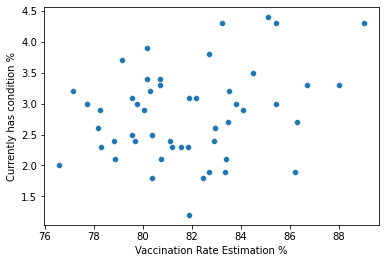

In [72]:
sns.scatterplot(y=asd_df['Currently has condition %'], x=asd_df['Vaccination Rate Estimation %'])
plt.show()

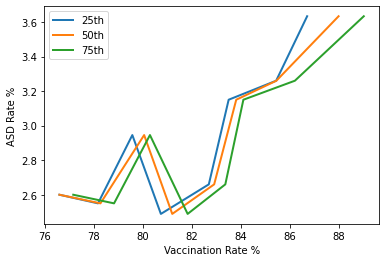

In [135]:
df = asd_df.dropna(subset=['Currently has condition %','Vaccination Rate Estimation %'])
bins = np.arange(76, 88, 1.5)
indices = np.digitize(df['Vaccination Rate Estimation %'], bins)
groups = df.groupby(indices)



asd_grp_mean = [group['Currently has condition %'].mean() for i, group in groups]
vacc_grp_cdfs = [cdf_array(group['Vaccination Rate Estimation %']) for i, group in groups]

for percent in [25, 50, 75]:
    label = f'{percent}th'
    vacc = [cdf_percentile(cdf_grp, percent) for cdf_grp in vacc_grp_cdfs]
    plt.plot(vacc, asd_grp_mean, label=label, linewidth=2)
    plt.legend()
    
plt.ylabel('ASD Rate %')
plt.xlabel('Vaccination Rate %')
plt.show()

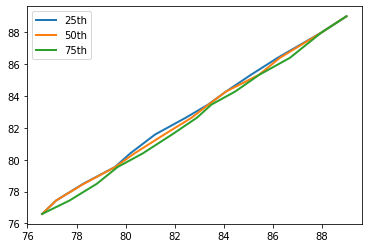

In [106]:
df = asd_df.dropna(subset=['Currently has condition %','Vaccination Rate Estimation %'])
bins = np.arange(75, 90, 1)
indices = np.digitize(df['Vaccination Rate Estimation %'], bins)
groups = df.groupby(indices)



vacc_grp_mean = [group['Vaccination Rate Estimation %'].mean() for i, group in groups]
vacc_grp_cdfs = [cdf_array(group['Vaccination Rate Estimation %']) for i, group in groups]

for percent in range(25, 76, 25):
    label = f'{percent}th'
    vacc = [cdf_percentile(cdf_grp, percent) for cdf_grp in vacc_grp_cdfs]
    plt.plot(vacc, vacc_grp_mean, label=label, linewidth=2)
    plt.legend()
    
# plt.xlabel('Binned height means (cm)')
# plt.ylabel('Binned weight percentiles (kg)')
plt.show()

In [101]:
for i, group in groups:
    print(group['Currently has condition %'])

0     3.1
1     3.2
2     3.3
3     2.5
4     3.0
5     1.9
6     3.3
7     4.4
8     2.9
9     2.3
10    1.8
11    2.3
12    2.9
13    2.9
14    1.9
15    1.2
16    2.3
17    3.9
18    3.8
19    3.0
20    4.3
21    2.6
22    2.7
23    2.3
24    2.1
25    2.4
26    2.7
27    2.6
28    4.3
29    3.4
30    3.1
31    2.1
32    3.2
33    1.9
34    3.0
35    3.7
36    3.1
37    3.5
38    3.3
39    3.2
40    2.4
41    2.4
42    3.4
43    1.8
44    2.1
45    3.0
46    2.4
47    2.5
48    4.3
49    2.0
Name: Currently has condition %, dtype: float64


<br>


## <span style="color:#ae8bd6">Variable Summary</span>


### ASD Rate

For children 3-17 years of age for years 2018-2019. Data obtained from the National Survey of Children's Health (NSCH).

<img src="Images/ASD Prevalence by State.jpg">

*Image created manually in Tableau. Data from external source.*

<span style="font-size:10px">

Data Reference: Child and Adolescent Health Measurement Initiative. 2018-2019 National Survey of Children’s Health (NSCH) data query. Data Resource Center for Child and Adolescent Health supported by the U.S. Department of Health and Human Services, Health Resources and Services Administration (HRSA), Maternal and Child Health Bureau (MCHB). Retrieved 12/2/2021 from [www.childhealthdata.org]
    
</span>

<br>

Summary Statistics:

In [ ]:
asd_array = np.array(asd_df['Currently has condition %'])

var_summary(asd_array, sup_title='ASD Rate')


***

<br>

### Father Age >= 40 Rate

Birth natality data for year 2016. Data obtained from CDC Wonder data bank.

<img src="Images/Father Age Rate 40.jpg">

*Image created manually in Tableau. Data from external source.*

<span style="font-size:10px">

Data Reference: Centers for Disease Control and Prevention. CDC Wonder. http://wonder.cdc.gov/. December 2021.
    
</span>

<br>

Summary Statistics:

In [ ]:
father_age_array = np.array(asd_df['Father Age >= 40 Rate'])

var_summary(father_age_array, sup_title='Father Age >= 40 Rate')

***

<br>

### Mother Age >= 40 Rate

Birth natality data for year 2016. Data obtained from CDC wonder data bank.

<img src="Images/Mother Age Rate 40.jpg">

*Image created manually in Tableau. Data from external source.*

<span style="font-size:10px">

Data Reference: Centers for Disease Control and Prevention. CDC Wonder. http://wonder.cdc.gov/. December 2021.
    
</span>

<br>

Summary Statistics:

In [ ]:
mother_age_array = np.array(asd_df['Mother Age >= 40 Rate'])

var_summary(mother_age_array, sup_title='Mother Age >= 40 Rate')

***

<br>

### Premature Births

Birth natality data for year 2016. Data obtained from CDC wonder data bank.

<img src="Images/Premature Birth Rate.jpg">

*Image created manually in Tableau. Data from external source.*

<span style="font-size:10px">

Data Reference: Centers for Disease Control and Prevention. CDC Wonder. http://wonder.cdc.gov/. December 2021.
    
</span>

<br>

Summary Statistics:

In [ ]:
premature_array = np.array(asd_df['Premature Birth Rate'])

var_summary(premature_array, sup_title='Premature Birth Rate')

***

<br>

### Population

Population for U.S. year 2020.

<img src="Images/Population.jpg">

*Image created manually in Tableau. Data from external source.*

<span style="font-size:10px">

Data Reference: 2020 U.S. Census. https://data.census.gov January 2022.
    
</span>

<br>

Summary Statistics:

- 

In [ ]:
pop_array = np.array(asd_df['Population'])

var_summary(pop_array, sup_title='Population')

***

<br>

### Obesity Rate

Obesity rate data for adults in year 2015. Data obtained from CDC BRFSS.

<img src="Images/Obesity Rate.jpg">

*Image created manually in Tableau. Data from external source.*

<span style="font-size:10px">

Data Reference: Centers for Disease Control and Prevention. BRFSS. http://cdc.gov/brfss. January 2022.
    
</span>

<br>

Summary Statistics:

In [ ]:
obese_array = np.array(asd_df['ObesityRate'])

var_summary(obese_array, sup_title='Obesity Rate')

***

<br>

### Binge Drinking Rate

Obesity rate data for adults in year 2015. Data obtained from CDC BRFSS.

<img src="Images/Binge Drinking Rate.jpg">

*Image created manually in Tableau. Data from external source.*

<span style="font-size:10px">

Data Reference: Centers for Disease Control and Prevention. BRFSS. http://cdc.gov/brfss. January 2022.
    
</span>

<br>

Summary Statistics:

In [ ]:
binge_array = asd_df['Binge_Drinking_%']

var_summary(binge_array, sup_title='Binge Drinking Rate', ax1_xlabel=' ', ax2_xlabel=' ')

***

<br>

### Vaccination Rate by State

For children 0-35 months of age. Survey taken for year 2021. Data obtained from the Center for Disease Control and Prevention (CDC).


<img src="Images/Vaccination Rate by State.jpg">

*Image created manually in Tableau. Data from external source.*

<span style="font-size:10px">

Data Reference: Vaccination Coverage among Young Children (0-35 Months) | Data | Centers for Disease Control and Prevention. (2021). Retrieved 2 December 2021, from https://data.cdc.gov/Child-Vaccinations/Vaccination-Coverage-among-Young-Children-0-35-Mon/fhky-rtsk
    
</span>

<br>

Summary Statistics:

In [ ]:
vacc_array = asd_df['Vaccination Rate Estimation %']

var_summary(vacc_array, sup_title='Vaccination Rate')

<br>

## 2 Scenarios

ASD Rate for states at or above the mean binge drinking rate and below the binge drinking rate.


In [ ]:
mean = sum(asd_df['Binge_Drinking_%']) / len(asd_df['Binge_Drinking_%'])

asd_df['Binge Above Mean?'] = np.where(asd_df['Binge_Drinking_%'] >= mean, 'Y', 'N')

binge_below = np.array(asd_df[asd_df['Binge Above Mean?']=='N']['Currently has condition %'])
binge_above = np.array(asd_df[asd_df['Binge Above Mean?']=='Y']['Currently has condition %'])

var_summary(binge_above, sup_title='Binge Drinking >= Mean'), var_summary(binge_below, sup_title='Binge Drinking < Mean')

plt.show()

<a id="_references"></a><br><br>

## <span style="color:#ae8bd6">References</span>    [<span style="font-size:12px">(*Home*)</span>](#_home)

<u>ASD Prevalence</u><br>
Child and Adolescent Health Measurement Initiative. 2018-2019 National Survey of Children’s Health (NSCH) data query. Data Resource Center for Child and Adolescent Health supported by the U.S. Department of Health and Human Services, Health Resources and Services Administration (HRSA), Maternal and Child Health Bureau (MCHB). Retrieved 12/2/2021 from [www.childhealthdata.org]

<br>

<u>Census Population</u><br>
Explore Census Data. (2021). Retrieved 2 December 2021, from https://data.census.gov/cedsci/

<br>

<u>Vaccination Rates</u><br>
Vaccination Coverage among Young Children (0-35 Months) | Data | Centers for Disease Control and Prevention. (2021). Retrieved 2 December 2021, from https://data.cdc.gov/Child-Vaccinations/Vaccination-Coverage-among-Young-Children-0-35-Mon/fhky-rtsk

<br>

<u>Birth Natality</u><br>
Centers for Disease Control and Prevention. CDC Wonder. http://wonder.cdc.gov/. December 2021.

<br>

<u>Obesity Rate</u><br>
CDC BRFSS. (2022). Retrieved 17 January 2022, from https://www.cdc.gov/brfss/

<br>

<u>Binge Drinking Rate</u><br>
CDC BRFSS. (2022). Retrieved 20 January 2022, from https://www.cdc.gov/brfss/